# 4.1 Imports

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns

from numpy import mean, std
from collections import Counter
import time
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import SparsePCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, recall_score, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load train data
train = pd.read_csv('data/train_prep_1.csv')

In [4]:
# load test data
test = pd.read_csv('data/test_prep_1.csv')

In [5]:
train.shape

(32462, 12)

In [6]:
test.shape

(16232, 12)

In [7]:
X_train = train.drop(columns=['target'])
X_train.shape

(32462, 11)

In [8]:
X_test = test.drop(columns=['target'])
X_test.shape

(16232, 11)

In [9]:
y_train = train['target']
y_train.shape

(32462,)

In [10]:
y_test = test['target']
y_test.shape

(16232,)

In [11]:
# temp, for deployment

train.columns

Index(['age', 'workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'capital_change', 'hours_per_week',
       'native_country', 'target'],
      dtype='object')

In [65]:
model_list = []
training_time_list = []
recall_score_list = []

# 4.2 Logistic Regression

In [13]:
# numerical features
num_features = ['age','education','hours_per_week']

# numerical transformer
num_transformer = StandardScaler()

In [14]:
# categorical features
cat_features = ['workclass','marital_status','occupation','relationship',
               'race','sex','capital_change','native_country']

# categorical transformer
cat_transformer = OneHotEncoder(handle_unknown='ignore')

In [15]:
# preprocessing

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

In [16]:
# whole model pipeline

logistic_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',LogisticRegression(random_state=20210510, n_jobs=-1))
])

In [17]:
# model fitting

start_time = time.time()

logistic_regression.fit(X_train, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'model training time: %.3fs' % training_time)

model training time: 10.621s


In [18]:
# model evaluation

def print_score(model):
    print('model score: %.3f' % model.score(X_test,y_test))
    print('\n')

In [19]:
# classification reports

def print_classfication_reports(model):
    y_test_pred = model.predict(X_test)

    print('Classification report on test data:')
    print(classification_report(y_test, y_test_pred))

    y_train_pred = model.predict(X_train)

    print('Classification report on train data:')
    print(classification_report(y_train, y_train_pred))

In [20]:
# model evaluation
print_score(logistic_regression)

# classification reports
print_classfication_reports(logistic_regression)

model score: 0.843


Classification report on test data:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     12397
           1       0.71      0.57      0.63      3835

    accuracy                           0.84     16232
   macro avg       0.79      0.75      0.77     16232
weighted avg       0.84      0.84      0.84     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     24635
           1       0.71      0.58      0.64      7827

    accuracy                           0.84     32462
   macro avg       0.79      0.75      0.77     32462
weighted avg       0.84      0.84      0.84     32462



In [21]:
# grid search 1

param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.1, 1.0, 10, 100]
}

grid_search = GridSearchCV(logistic_regression, param_grid, scoring='recall', verbose=1, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params:
{'classifier__C': 100, 'classifier__penalty': 'l2'}


In [22]:
# grid search 2

param_grid = {
    'classifier__penalty': ['l2'],
    'classifier__C': [100, 200, 300, 400, 500]
}

grid_search = GridSearchCV(logistic_regression, param_grid, scoring='recall', verbose=1, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:
{'classifier__C': 300, 'classifier__penalty': 'l2'}


In [23]:
# whole model pipeline with best params

logistic_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',LogisticRegression(C=300, random_state=20210510, n_jobs=-1))
])

# model fitting

start_time = time.time()

logistic_regression.fit(X_train, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'model training time: %.3fs' % training_time)

# model evaluation
print_score(logistic_regression)

# classification reports
print_classfication_reports(logistic_regression)

model training time: 1.853s
model score: 0.843


Classification report on test data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     12397
           1       0.71      0.57      0.63      3835

    accuracy                           0.84     16232
   macro avg       0.79      0.75      0.77     16232
weighted avg       0.83      0.84      0.84     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     24635
           1       0.71      0.58      0.64      7827

    accuracy                           0.84     32462
   macro avg       0.79      0.75      0.77     32462
weighted avg       0.84      0.84      0.84     32462



In [66]:
# best of logistic regression

model = 'logistic regression'
training_time = 1.85
recall_score = 0.57

model_list.append(model)
training_time_list.append(training_time)
recall_score_list.append(recall_score)

# 4.3 Logistic Regression with ADASYN

In [25]:
# preprocessing stay the same
# only edit the whole model pipeline

In [26]:
# oversampler
adasyn = ADASYN(random_state=20210517,n_jobs=-1)

In [27]:
# as 'pipeline' in sklearn library does not support 'adasyn'
# 'adasyn' function has no .fit_transform
# have to use 'make_pipeline' in imblearn library

logistic_adasyn = make_pipeline(preprocessor, adasyn ,LogisticRegression(random_state=20210510, n_jobs=-1))

In [28]:
# model fitting

start_time = time.time()

logistic_adasyn.fit(X_train, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'model training time: %.3fs' % training_time)

model training time: 47.492s


In [29]:
# model evaluation
print_score(logistic_adasyn)

# classification reports
print_classfication_reports(logistic_adasyn)

model score: 0.771


Classification report on test data:
              precision    recall  f1-score   support

           0       0.95      0.74      0.83     12397
           1       0.51      0.87      0.64      3835

    accuracy                           0.77     16232
   macro avg       0.73      0.81      0.74     16232
weighted avg       0.85      0.77      0.79     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.95      0.74      0.83     24635
           1       0.52      0.88      0.65      7827

    accuracy                           0.77     32462
   macro avg       0.74      0.81      0.74     32462
weighted avg       0.85      0.77      0.79     32462



In [67]:
# best of logistic regression with ADASYN

model = 'logistic with ADASYN'
training_time = 47.49
recall_score = 0.87

model_list.append(model)
training_time_list.append(training_time)
recall_score_list.append(recall_score)

# 4.4 Linear Support Vector Classification (SVC)

In [31]:
# preprocessing stay the same
# only edit the whole model pipeline

In [32]:
# whole model pipeline

linear_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',LinearSVC(random_state=20210518))
])

In [33]:
# model fitting

start_time = time.time()

linear_svc.fit(X_train, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'model training time: %.3fs' % training_time)

model training time: 4.699s


In [34]:
# model evaluation
print_score(linear_svc)

# classification reports
print_classfication_reports(linear_svc)

model score: 0.844


Classification report on test data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     12397
           1       0.71      0.57      0.63      3835

    accuracy                           0.84     16232
   macro avg       0.79      0.75      0.77     16232
weighted avg       0.84      0.84      0.84     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     24635
           1       0.72      0.57      0.64      7827

    accuracy                           0.84     32462
   macro avg       0.80      0.75      0.77     32462
weighted avg       0.84      0.84      0.84     32462



In [35]:
# grid search

param_grid = {
    'classifier__C': [0.1, 1.0, 10, 100]
}

grid_search = GridSearchCV(linear_svc, param_grid, scoring='recall', verbose=1, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params:
{'classifier__C': 1.0}


In [36]:
# whole model pipeline with best params

linear_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',LinearSVC(C=1.0, random_state=20210518))
])

# model fitting

start_time = time.time()

linear_svc.fit(X_train, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'model training time: %.3fs' % training_time)

# model evaluation
print_score(linear_svc)

# classification reports
print_classfication_reports(linear_svc)

model training time: 6.405s
model score: 0.844


Classification report on test data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     12397
           1       0.71      0.57      0.63      3835

    accuracy                           0.84     16232
   macro avg       0.79      0.75      0.77     16232
weighted avg       0.84      0.84      0.84     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     24635
           1       0.72      0.57      0.64      7827

    accuracy                           0.84     32462
   macro avg       0.80      0.75      0.77     32462
weighted avg       0.84      0.84      0.84     32462



In [68]:
# best of linear SVC

model = 'linear SVC'
training_time = 6.41
recall_score = 0.57

model_list.append(model)
training_time_list.append(training_time)
recall_score_list.append(recall_score)

# 4.5 K Nearest Neighbors Classification

In [38]:
# preprocessing stay the same
# only edit the whole model pipeline

In [39]:
# whole model pipeline

kneighbors = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',KNeighborsClassifier())
])

In [40]:
# model fitting

start_time = time.time()

kneighbors.fit(X_train, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'model training time: %.3fs' % training_time)

model training time: 0.555s


In [41]:
# model evaluation
print_score(kneighbors)

# classification reports
print_classfication_reports(kneighbors)

model score: 0.825


Classification report on test data:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     12397
           1       0.64      0.58      0.61      3835

    accuracy                           0.82     16232
   macro avg       0.76      0.74      0.75     16232
weighted avg       0.82      0.82      0.82     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     24635
           1       0.77      0.69      0.73      7827

    accuracy                           0.88     32462
   macro avg       0.84      0.81      0.82     32462
weighted avg       0.87      0.88      0.87     32462



In [42]:
# grid search

param_grid = {
    'classifier__n_neighbors': [5, 10, 25, 50, 100]
}

grid_search = GridSearchCV(kneighbors, param_grid, scoring='recall', verbose=1)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:
{'classifier__n_neighbors': 25}


In [43]:
# whole model pipeline with best params

kneighbors = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',KNeighborsClassifier(n_neighbors=25))
])

# model fitting

start_time = time.time()

kneighbors.fit(X_train, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'model training time: %.3fs' % training_time)

# model evaluation
print_score(kneighbors)

# classification reports
print_classfication_reports(kneighbors)

model training time: 0.246s
model score: 0.843


Classification report on test data:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     12397
           1       0.70      0.60      0.64      3835

    accuracy                           0.84     16232
   macro avg       0.79      0.76      0.77     16232
weighted avg       0.84      0.84      0.84     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     24635
           1       0.73      0.63      0.68      7827

    accuracy                           0.85     32462
   macro avg       0.81      0.78      0.79     32462
weighted avg       0.85      0.85      0.85     32462



In [69]:
# best of K nearest neighbor classification

model = 'K nearest neighbor'
training_time = 0.25
recall_score = 0.60

model_list.append(model)
training_time_list.append(training_time)
recall_score_list.append(recall_score)

# 4.6 Decision Tree Classification

In [45]:
# preprocessing stay the same
# only edit the whole model pipeline

In [46]:
# whole model pipeline

decision_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=20210521, class_weight='balanced'))
])

In [47]:
# model fitting

start_time = time.time()

decision_tree.fit(X_train, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'model training time: %.3fs' % training_time)

model training time: 2.871s


In [48]:
# model evaluation
print_score(decision_tree)

# classification reports
print_classfication_reports(decision_tree)

model score: 0.783


Classification report on test data:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     12397
           1       0.54      0.60      0.57      3835

    accuracy                           0.78     16232
   macro avg       0.70      0.72      0.71     16232
weighted avg       0.79      0.78      0.79     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     24635
           1       0.86      0.99      0.92      7827

    accuracy                           0.96     32462
   macro avg       0.93      0.97      0.95     32462
weighted avg       0.96      0.96      0.96     32462



In [49]:
# grid search 1

depth = [
    1, 2, 3, 4, 5,
    6, 7, 8, 9, 10,
    12, 14, 16, 18, 20
]

num_leaf = [
    1, 2, 3, 4, 5,
    6, 7, 8, 9, 10,
    12, 14, 16, 18, 20
]

param_grid = {
        'classifier__max_depth': depth,
        'classifier__min_samples_leaf': num_leaf
}

grid_search = GridSearchCV(decision_tree, param_grid, scoring='recall', verbose=1, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
Best params:
{'classifier__max_depth': 6, 'classifier__min_samples_leaf': 4}


In [50]:
# whole model pipeline with best params

decision_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, random_state=20210521, class_weight='balanced'))
])

# model fitting

start_time = time.time()

decision_tree.fit(X_train, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'model training time: %.3fs' % training_time)

# model evaluation
print_score(decision_tree)

# classification reports

print_classfication_reports(decision_tree)

model training time: 0.968s
model score: 0.759


Classification report on test data:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     12397
           1       0.49      0.88      0.63      3835

    accuracy                           0.76     16232
   macro avg       0.72      0.80      0.73     16232
weighted avg       0.84      0.76      0.78     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     24635
           1       0.51      0.89      0.65      7827

    accuracy                           0.76     32462
   macro avg       0.73      0.81      0.74     32462
weighted avg       0.85      0.76      0.78     32462



In [70]:
# best of decision tree classification

model = 'decision tree'
training_time = 0.97
recall_score = 0.88

model_list.append(model)
training_time_list.append(training_time)
recall_score_list.append(recall_score)

In [52]:
# save model

file_name = 'decision_tree_model.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(decision_tree, file)

In [53]:
# for application
# load model

# file_name = 'decision_tree_model.pkl'
# with open(file_name, 'rb') as file:
#     model = pickle.load(file)

# 4.7 Adaptive Boosting (Adaboost) Classification

In [54]:
# preprocessing stay the same
# only edit the whole model pipeline

In [55]:
# whole model pipeline

adaboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=60, random_state=20210521, class_weight='balanced'),
        random_state=20210526))
])

In [56]:
# model fitting

start_time = time.time()

adaboost.fit(X_train, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'model training time: %.3fs' % training_time)

model training time: 27.585s


In [57]:
# model evaluation
print_score(adaboost)

# classification reports
print_classfication_reports(adaboost)

model score: 0.805


Classification report on test data:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12397
           1       0.58      0.61      0.60      3835

    accuracy                           0.81     16232
   macro avg       0.73      0.74      0.73     16232
weighted avg       0.81      0.81      0.81     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     24635
           1       0.86      0.99      0.92      7827

    accuracy                           0.96     32462
   macro avg       0.93      0.97      0.95     32462
weighted avg       0.96      0.96      0.96     32462



In [71]:
# best of AdaBoost classification

model = 'AdaBoost'
training_time = 27.59
recall_score = 0.61

model_list.append(model)
training_time_list.append(training_time)
recall_score_list.append(recall_score)

# 4.8 Performance Metrics Comparison

In [72]:
df = pd.DataFrame({
    'model': model_list,
    'training_time': training_time_list,
    'recall_score': recall_score_list
})

In [73]:
df

,model,training_time,recall_score
0,logistic regression,1.85,0.57
1,logistic with ADASYN,47.49,0.87
2,linear SVC,6.41,0.57
3,K nearest neighbor,0.25,0.60
4,decision tree,0.97,0.88
5,AdaBoost,27.59,0.61


In [74]:
df['efficiency (1/time)'] = df.training_time.apply(lambda x: 1/x)

In [75]:
df

,model,training_time,recall_score,efficiency (1/time)
0,logistic regression,1.85,0.57,0.540541
1,logistic with ADASYN,47.49,0.87,0.021057
2,linear SVC,6.41,0.57,0.156006
3,K nearest neighbor,0.25,0.60,4.000000
4,decision tree,0.97,0.88,1.030928
5,AdaBoost,27.59,0.61,0.036245


<AxesSubplot:label='e8da991c-e490-431f-a426-2cded872ec8b', xlabel='model', ylabel='recall_score'>

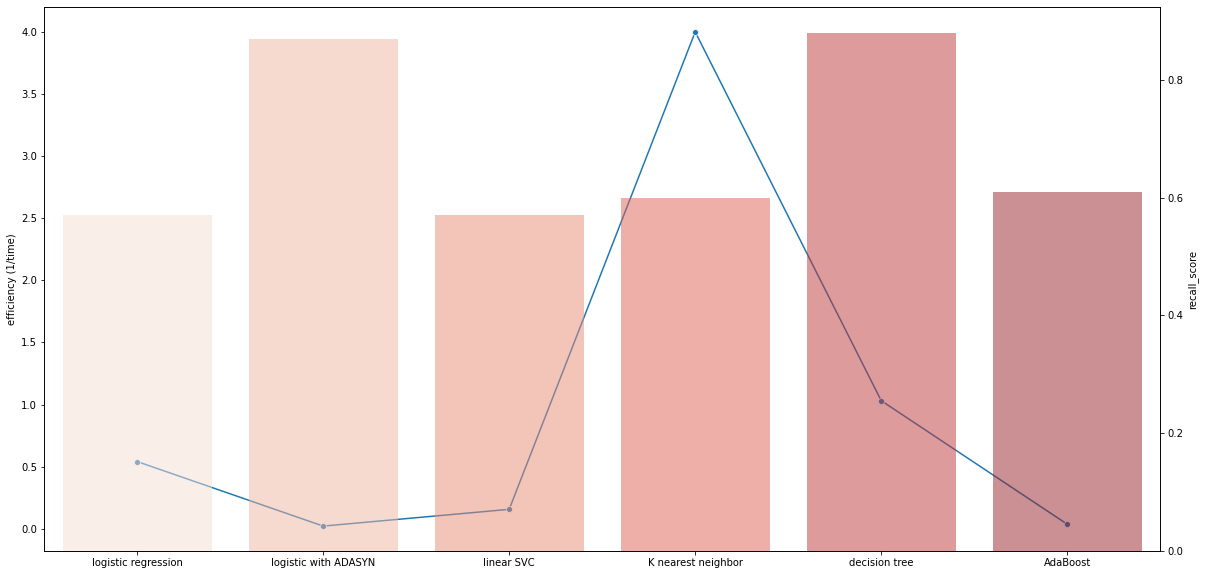

In [76]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()

sns.lineplot(data=df['efficiency (1/time)'], marker='o', sort=False, ax=ax1, palette='Reds')
sns.barplot(data=df, x='model', y='recall_score', alpha=0.5, ax=ax2, palette='Reds')

In [ ]:
# from the above table, we can come to a conclusion
# the decision tree classification method has the highest recall score and second best efficiency
# therefore the decision tree classification model will be used in the deployment application

In [64]:
#END